In [431]:
import numpy as np
import horus,os
import imageio
from astropy import units
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.interpolate import interp1d
from matplotlib.patches import PathPatch
from photutils import CircularAperture, ApertureMask

parula_colors=np.load('/Users/arcticfox/parula_colors.npy')

COLOR = 'w'

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 9

In [83]:
def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

In [78]:
def discrete_star(res):

    x = np.linspace(-1.0, 1.0, res)
    y = np.linspace(-1.0, 1.0, res)

    z = np.ones(res**2).reshape(res,res)

    xx, yy = np.meshgrid(x, y, sparse=True)

    r = np.sqrt(xx**2 + yy**2)
    z[r >1] = 0

    lat = np.arcsin(yy)
    lon = np.arcsin(xx)

    v_diffrot = 100*z*np.cos(lat)*np.sin(lon) *np.cos(lat/1.0)
    v = 100*z*np.cos(lat)*np.sin(lon)

    rx, ry = np.where(z==0)
    z[rx,ry]=np.nan
    
    for i in range(100):
        ind = np.where(np.isnan(z[i])==False)[0]
        z[i][ind] = ind

    return z

In [136]:
def upside_down_gauss(x, mu, sig, f):
    term1 = f / (sig * np.sqrt(2 * np.pi))
    e = -0.5 * (x - mu)**2 / sig**2
    return -term1 * np.exp(e)
def gauss(x, mu, sig, f):
    term1 = f / (sig * np.sqrt(2 * np.pi))
    e = -0.5 * (x - mu)**2 / sig**2
    return term1 * np.exp(e)

In [376]:
def expanding_bins(lines, repeat=3, subtract=True, med=None):
    global time
    
    if med is None:
        med = np.nanmedian(lines, axis=0)
    binned = np.zeros( (len(time)*repeat, len(lines[0]))  )
            
    z = 0
    for i in range(len(lines)):
        if subtract == True:
            binned[z:z+repeat] = lines[i] - med
        else:
            binned[z:z+repeat] = lines[i]
        z += repeat
    return binned, med

In [196]:
key = 'caIII'
data = np.load('v1298_{}.pkl'.format(key), allow_pickle=True)
time = data['ttime']+0.0
expt = data['texptime']+0.0

In [444]:
len(centers)

43

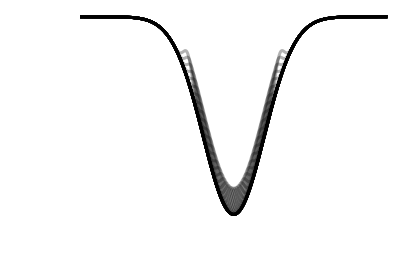

In [464]:
centers = np.linspace(656.0, 656.6, len(time)-10)
x = np.linspace(655.3,657.3,1000)
yerr = np.full(len(x), 0.001)

linemodels = np.zeros((len(time), len(x)))

for i in range(len(centers)):
    
    y = upside_down_gauss(x, 656.3, 0.2, 0.5)
    
    yp = gauss(x, centers[i], 0.03, 1e-2)
    
    yp[yp<0.005]=np.nan
    new = yp+y
    y[yp>0.005]=yp[yp>0.005]+y[yp>0.005]
    linemodels[i+5] = y
    plt.plot(x, y, 'k', lw=3, alpha=0.3)


In [383]:
grid = discrete_star(100)

In [420]:
rsize=100
rstar = rsize/2.0
rprstar = 0.04246
equator = rsize/2.0

duration = ( 4.66 * units.hour).to(units.day).value
time_start_ind=5
planet_steps = np.arange(5,53-5,1)
centers = np.linspace(0, rsize, len(planet_steps))

planet_masked = np.zeros((len(centers), grid.shape[0], rsize))
equator = int(grid.shape[0]/2)


for i in range(len(centers)):
    ap = CircularAperture(r=5.0, positions=[centers[i], equator])
    mask = ap.to_mask()

    image = mask.to_image(shape=(planet_masked[0].shape))
    bool_img = np.array(image, dtype=bool)
    int_img = np.array(~bool_img, dtype=float)
    fullmask = np.full(planet_masked[0].shape, np.nan)
    
    xr, yr = np.where(int_img!=1)
    fullmask[xr, yr]=0.0
    planet_masked[i] = fullmask
    #np.save('planet_mask_{0:03d}.npy', int_img)

In [421]:
blue = '#0a2bff'
red = '#ff0a1a'

from matplotlib.colors import LinearSegmentedColormap

clist = np.array([blue, red])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

clist = np.array(['#000000', parula_colors[60], '#FFFFFF'
                  
                  ])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm_paper = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

In [422]:
plt.rcParams['font.size'] = 18

In [466]:
bkg = np.full(linemodels.shape, linemodels[0])
waterfall_bkg, _ = expanding_bins(bkg, 8, subtract=False)

In [547]:
plotdir = '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim'

In [549]:
winterp = interp1d(np.arange(0,len(x),1), x)

for i in range(len(time)):

    fig = plt.figure(constrained_layout=True, figsize=(14,4))
    gs = fig.add_gridspec(1,3)
    fig.set_facecolor('#0E0E0E')
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    ax1.imshow(grid, cmap=cm)
    if i >= planet_steps[0] and i <= planet_steps[-1]:
        ax1.imshow(planet_masked[i-5], cmap='Greys')
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_xticks([]); ax1.set_yticks([])   

    
    
    if i >= planet_steps[0] and i <= planet_steps[-1]:
        waterfall, _ = expanding_bins(linemodels[:i+1], 8, med=linemodels[0])
        xr, yr = np.where(waterfall==0)
        waterfall[xr,yr] = np.nan

        ax3.imshow(waterfall_bkg, origin='lower', cmap=cm_paper)
        im = ax3.imshow(waterfall, origin='lower', cmap=cm_paper)
        
        ax2.plot(x, linemodels[i], COLOR, lw=4)
    else:
        ax2.plot(x, upside_down_gauss(x, 656.3, 0.2, 0.5), 
                 COLOR, lw=4)
        waterfall, _ = expanding_bins(linemodels, 8, subtract=False)#med=linemodels[0])
        xr, yr = np.where(waterfall==0)
        waterfall[xr,yr] = np.nan
        im = ax3.imshow(waterfall, origin='lower', cmap=cm_paper,
                       vmin=-1, vmax=0)
        
    ax3.set_yticks([])
    cbar = plt.colorbar(im)
    cbar.set_ticks([])
    cbar.set_label('Fractional Deviation', x=1.1)
    ticks = [350,500,650]
    ax3.set_xticks(ticks)
    ax3.set_xticklabels(np.round(winterp(ticks),2))
    ax2.set_xticks(np.linspace(x[0], x[-1], 5))
    
    ax2.set_xlabel('Wavelength [nm]', fontsize=22)
    ax3.set_xlabel('Wavelength [nm]', fontsize=22)
    ax2.set_yticks([])

    ax3.set_xlim(300,700)
    
    plt.savefig(os.path.join(plotdir, 'figure_{0:02d}.png'.format(i)),
                rasterize=True, bbox='tight', dpi=300)
    plt.close()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_laun

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_laun

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
//anaconda3/lib/python3.7/site-packages/ipykernel_laun

In [550]:
filenames = np.sort([os.path.join(plotdir, i) for i in os.listdir(plotdir)])

In [551]:
filenames

array(['/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_00.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_01.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_02.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_03.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_04.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_05.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_06.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_07.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_08.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_09.png',
       '/Users/arcticfox/Documents/atmospheres/v1298tau/misttborn/longanim/figure_10.png',

In [ ]:
with imageio.get_writer('dt_example_long.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)